# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [12]:
a = np.array([[2, 4, 6], [8, 12, -12]])
b = np.sum(a, axis=1)[:, np.newaxis]
print(a)
print(b)
np.divide(a, b)

[[  2   4   6]
 [  8  12 -12]]
[[12]
 [ 8]]


array([[ 0.16666667,  0.33333333,  0.5       ],
       [ 1.        ,  1.5       , -1.5       ]])

In [13]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.339926
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

This is because there are 10 classes, an in the beginning, each of them 
will have equal probability of 1/10.



In [28]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.040175 analytic: 0.040175, relative error: 3.478980e-07
numerical: 1.587341 analytic: 1.587341, relative error: 2.518177e-08
numerical: 2.242165 analytic: 2.242165, relative error: 2.710344e-08
numerical: -2.502862 analytic: -2.502862, relative error: 2.185376e-08
numerical: 2.093125 analytic: 2.093125, relative error: 3.385299e-08
numerical: 1.300568 analytic: 1.300568, relative error: 1.995714e-09
numerical: 1.585166 analytic: 1.585166, relative error: 3.576378e-08
numerical: -1.032659 analytic: -1.032659, relative error: 1.351464e-09
numerical: -4.053234 analytic: -4.053234, relative error: 9.786896e-09
numerical: 1.561634 analytic: 1.561634, relative error: 6.230482e-08
numerical: -1.243344 analytic: -1.243344, relative error: 1.015231e-08
numerical: -0.339310 analytic: -0.339310, relative error: 4.882402e-08
numerical: -0.689442 analytic: -0.689442, relative error: 1.954965e-08
numerical: 0.095477 analytic: 0.095477, relative error: 2.819530e-07
numerical: 1.702491 an

In [36]:
x = np.array([[2, 3, 4], [8, 12, -12]])  # 2x3 
probs = np.array([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8]])  # 2 x 4
print(x)
print(probs)
dw= np.array([np.dot(x[i].T[:, np.newaxis], probs[i][np.newaxis, :]) for i in range(2)])
dw1= np.mean(dw, axis=0)
print(dw1)
dw2 = np.dot(x.T, probs) / 2

y = np.array([3, 1])
one_hot_targets = np.eye(4)[y]
one_hot_targets.shape
probs.shape

[[  2   3   4]
 [  8  12 -12]]
[[0.1 0.2 0.3 0.4]
 [0.5 0.6 0.7 0.8]]
[[ 2.1   2.6   3.1   3.6 ]
 [ 3.15  3.9   4.65  5.4 ]
 [-2.8  -3.2  -3.6  -4.  ]]


(2, 4)

In [37]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.339926e+00 computed in 0.083281s
vectorized loss: 2.339926e+00 computed in 0.005339s
Loss difference: 0.000000
Gradient difference: 0.000000


In [39]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
sfc = Softmax()
tic = time.time()
loss_hist = sfc.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 772.702611
iteration 100 / 1500: loss 283.705564
iteration 200 / 1500: loss 105.176208
iteration 300 / 1500: loss 39.785550
iteration 400 / 1500: loss 15.957532
iteration 500 / 1500: loss 7.136293
iteration 600 / 1500: loss 3.900661
iteration 700 / 1500: loss 2.829374
iteration 800 / 1500: loss 2.369629
iteration 900 / 1500: loss 2.190646
iteration 1000 / 1500: loss 2.127344
iteration 1100 / 1500: loss 2.131599
iteration 1200 / 1500: loss 2.110286
iteration 1300 / 1500: loss 2.073042
iteration 1400 / 1500: loss 2.090488
That took 9.219692s


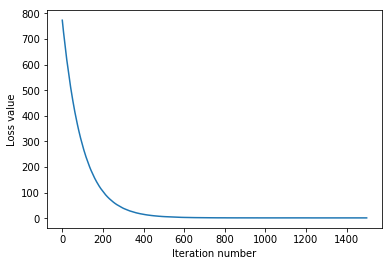

In [40]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [41]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = sfc.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = sfc.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.328510
validation accuracy: 0.337000


In [42]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
for rate in learning_rates:
    for reg in regularization_strengths:
        sfm = Softmax()
        loss_hist = sfm.train(X_train, y_train, learning_rate=rate, reg=reg,
                      num_iters=1501, verbose=True)
        train_acc = np.mean(y_train == sfm.predict(X_train))
        val_acc = np.mean(y_val == sfm.predict(X_val))
        results[(rate, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = sfm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1501: loss 766.475678
iteration 100 / 1501: loss 281.421476
iteration 200 / 1501: loss 104.484913
iteration 300 / 1501: loss 39.532615
iteration 400 / 1501: loss 15.782613
iteration 500 / 1501: loss 7.134670
iteration 600 / 1501: loss 3.916716
iteration 700 / 1501: loss 2.784172
iteration 800 / 1501: loss 2.346642
iteration 900 / 1501: loss 2.110022
iteration 1000 / 1501: loss 2.104145
iteration 1100 / 1501: loss 2.122597
iteration 1200 / 1501: loss 2.125109
iteration 1300 / 1501: loss 2.078062
iteration 1400 / 1501: loss 2.083872
iteration 1500 / 1501: loss 2.097037
iteration 0 / 1501: loss 1555.665143
iteration 100 / 1501: loss 209.474572
iteration 200 / 1501: loss 29.873572
iteration 300 / 1501: loss 5.880585
iteration 400 / 1501: loss 2.585506
iteration 500 / 1501: loss 2.204884
iteration 600 / 1501: loss 2.114284
iteration 700 / 1501: loss 2.110374
iteration 800 / 1501: loss 2.129904
iteration 900 / 1501: loss 2.181584
iteration 1000 / 1501: loss 2.152884
iteration 1

In [43]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.340000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: 

True

*Your explanation*:

For SVM:
It's possible that the new datapoint is far from the boundary and thus, the correct score > other scores + margin, and hence, will not contribute to the loss (since it is a hinge loss).

However for Softmax:
No matter how far the point is from the boundary, it will still contribute to the probability of the correct label and affect the loss.



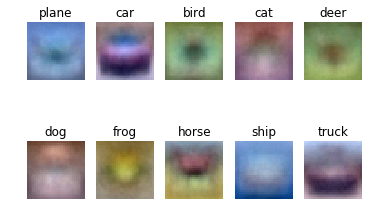

In [48]:
# Plotting
w = best_softmax.W[:-1, :].reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(len(classes)):
    plt.subplot(2, 5, i+1)
    wimg = 255.0 * (w[:,:,:,i] - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

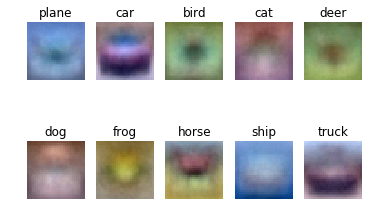

In [44]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])